In [1]:
#CW
import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2
from tools import show_images_diff

In [2]:
#获取计算设备 默认是CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#图像加载以及预处理
image_path="../picture/cropped_panda.jpg"
orig = cv2.imread(image_path)[..., ::-1]
orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img=np.expand_dims(img, axis=0)

print(img.shape)

#使用预测模式 主要影响droupout和BN层的行为
model = models.alexnet(pretrained=True).to(device).eval()


(1, 3, 224, 224)


In [3]:
#adam的最大迭代次数 论文中建议10000次 测试阶段1000也可以 1000次可以完成95%的优化工作
max_iterations=1000
#adam学习速率
learning_rate=0.01
#二分查找最大次数
binary_search_steps=10
#c的初始值
initial_const=1
confidence=initial_const

#k值
k=40

#像素值区间
boxmin = -3.0
boxmax = 3.0

#类别数 pytorch的实现里面是1000
num_labels=1000

#攻击目标标签 必须使用one hot编码
target_label=288
tlab=Variable(torch.from_numpy(np.eye(num_labels)[target_label]).to(device).float())


print()

shape = (1,3,224,224)


In [4]:


#c的初始化边界
lower_bound = 0
c=initial_const
upper_bound = 1e10

# the best l2, score, and image attack
o_bestl2 = 1e10
o_bestscore = -1
o_bestattack = [np.zeros(shape)]



In [5]:
import torch.nn.functional as F

# the resulting image, tanh'd to keep bounded from boxmin to boxmax
boxmul = (boxmax - boxmin) / 2.
boxplus = (boxmin + boxmax) / 2.

for outer_step in range(binary_search_steps):
    print("o_bestl2={} confidence={}".format(o_bestl2,confidence)  )
    
    #把原始图像转换成图像数据和扰动的形态
    timg = Variable(torch.from_numpy(np.arctanh((img - boxplus) / boxmul * 0.999999)).to(device).float())
    modifier=Variable(torch.zeros_like(timg).to(device).float())
    

    #设置为不保存梯度值 自然也无法修改
    #for param in model.parameters():
    #    param.requires_grad = False
        
    #图像数据的扰动量梯度可以获取
    modifier.requires_grad = True
    

    #定义优化器 仅优化modifier
    optimizer = torch.optim.Adam([modifier],lr=learning_rate)
    
    for iteration in range(1,max_iterations+1):
        optimizer.zero_grad()
        
        #定义新输入
        newimg = torch.tanh(modifier + timg) * boxmul + boxplus
      
        output=model(newimg)
             
        #定义cw中的损失函数
        
        #l2范数
        #l2dist = tf.reduce_sum(tf.square(newimg-(tf.tanh(timg) * boxmul + boxplus)),[1,2,3])
        #loss2 = tf.reduce_sum(l2dist)
        loss2=torch.dist(newimg,(torch.tanh(timg) * boxmul + boxplus),p=2)
        
        """
        # compute the probability of the label class versus the maximum other
            real = tf.reduce_sum((tlab)*output,1)
            # 论文中的开源实现 other = tf.reduce_max((1-tlab)*output - (tlab*10000),1)
            other = tf.reduce_max((1-tlab)*output)
            loss1 = tf.maximum(0.0, other-real+k)
            loss1 = tf.reduce_sum(const*loss1)
        """
               
        real=torch.max(output*tlab)
        other=torch.max((1-tlab)*output)  
        loss1=other-real+k   
        loss1=torch.clamp(loss1,min=0)
             
        loss1=confidence*loss1
           
        loss=loss1+loss2
               
        loss.backward(retain_graph=True)

        optimizer.step()
              
        l2=loss2
        
        sc=output.data.cpu().numpy()
        
        
        #输出的是概率
        pro=F.softmax(model(newimg),dim=1)[0].data.cpu().numpy()[target_label]
         
        # print out the losses every 10%
        if iteration%(max_iterations//10) == 0:
            print("iteration={} loss={} loss1={} loss2={} pro={}".format(iteration,loss,loss1,loss2,pro))
              
        if (l2 < o_bestl2) and (np.argmax(sc) == target_label  ) and ( pro > 0.8  ):
        #if (l2 < o_bestl2) and (np.argmax(sc) == target_label  ) :
            print("attack success l2={} target_label={} pro={}".format(l2,target_label,pro))
            o_bestl2 = l2
            o_bestscore = np.argmax(sc)
            o_bestattack = newimg.data.cpu().numpy()
            
    confidence_old=-1       
    if (o_bestscore == target_label) and o_bestscore != -1:
        #攻击成功 减小c
        upper_bound = min(upper_bound,confidence)
        if upper_bound < 1e9:
                print()
                confidence_old=confidence
                confidence = (lower_bound + upper_bound)/2
    else:
        lower_bound = max(lower_bound,confidence)
        confidence_old=confidence
        if upper_bound < 1e9:
                confidence = (lower_bound + upper_bound)/2
        else:
                confidence *= 10
                
    print("outer_step={} confidence {}->{}".format(outer_step,confidence_old,confidence))

o_bestl2=10000000000.0 confidence=1
attack success l2=12.031506538391113 target_label=288 pro=0.8148753643035889
attack success l2=11.90378475189209 target_label=288 pro=0.9941806197166443
attack success l2=11.758527755737305 target_label=288 pro=0.9945294260978699
attack success l2=11.716538429260254 target_label=288 pro=0.9931824803352356
attack success l2=11.71518611907959 target_label=288 pro=0.9942597150802612
attack success l2=11.682395935058594 target_label=288 pro=0.9949896931648254
attack success l2=11.60254192352295 target_label=288 pro=0.9957139492034912
attack success l2=11.540553092956543 target_label=288 pro=0.9956106543540955
attack success l2=11.492525100708008 target_label=288 pro=0.993301510810852
attack success l2=11.428533554077148 target_label=288 pro=0.9966861605644226
attack success l2=11.345378875732422 target_label=288 pro=0.9961705803871155
attack success l2=11.299781799316406 target_label=288 pro=0.9946685433387756
attack success l2=11.279762268066406 target_

iteration=800 loss=1.9808411598205566 loss1=1.6400054693222046 loss2=0.34083569049835205 pro=3.514691343298182e-06
iteration=900 loss=1.8790069818496704 loss1=1.6295355558395386 loss2=0.24947144091129303 pro=4.814667590835597e-06
iteration=1000 loss=1.9105263948440552 loss1=1.63254714012146 loss2=0.2779792249202728 pro=4.406711468618596e-06

outer_step=5 confidence 0.03125->0.015625
o_bestl2=6.4683051109313965 confidence=0.015625
iteration=100 loss=1.1395273208618164 loss1=0.8197723627090454 loss2=0.3197549879550934 pro=3.5590730931289727e-06
iteration=200 loss=1.0964336395263672 loss1=0.82062828540802 loss2=0.27580538392066956 pro=3.379696408956079e-06
iteration=300 loss=1.1153264045715332 loss1=0.8247888684272766 loss2=0.2905374765396118 pro=2.613495553305256e-06
iteration=400 loss=0.9968975782394409 loss1=0.8186472654342651 loss2=0.17825032770633698 pro=3.8048722217354225e-06
iteration=500 loss=1.0396549701690674 loss1=0.8224318027496338 loss2=0.2172231674194336 pro=3.01588283946330

In [6]:
print(o_bestattack.shape)
print(img.shape)

(1, 3, 224, 224)
(1, 3, 224, 224)


In [7]:
adv=o_bestattack[0]
print(adv.shape)
adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 256.0
adv = np.clip(adv, 0, 255).astype(np.uint8)


(3, 224, 224)


In [8]:
def infer_img(img,t=0):
    import torch.nn.functional as F
    
    img=img.astype(np.float32)
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img /= 255.0
    img = (img - mean) / std
    img = img.transpose(2, 0, 1)

    img=np.expand_dims(img, axis=0)

    img = Variable(torch.from_numpy(img).to(device).float())
    #print(img.shape)

    #使用预测模式 主要影响droupout和BN层的行为
    model = models.alexnet(pretrained=True).to(device).eval()
      
    output=F.softmax(model(img),dim=1)
        
    label=np.argmax(output.data.cpu().numpy())
    
    pro=output.data.cpu().numpy()[0][label]
    
    #当t不为0时返回指定类别的概率
    if t != 0:
        pro=output.data.cpu().numpy()[0][t]
        
    return pro

In [9]:
print(infer_img(orig))
print(infer_img(orig,t=288))
print(infer_img(orig,t=388))
print(infer_img(adv))
print(infer_img(adv,t=288))
print(infer_img(adv,t=388))

0.9270878
3.1756701e-06
0.9270878
0.8065012
0.8065012
0.00220799


std=0 adv_pro[388]=0.0022197833750396967 original_pro[388]=0.927069902420044
std=10 adv_pro[388]=0.4793362617492676 original_pro[388]=0.9134399890899658
std=20 adv_pro[388]=0.6202260255813599 original_pro[388]=0.851268470287323
std=30 adv_pro[388]=0.677721381187439 original_pro[388]=0.8163094520568848
std=40 adv_pro[388]=0.7062337398529053 original_pro[388]=0.8003881573677063
std=50 adv_pro[388]=0.6503924131393433 original_pro[388]=0.7744521498680115
std=60 adv_pro[388]=0.6066499352455139 original_pro[388]=0.7260379195213318
std=70 adv_pro[388]=0.5381486415863037 original_pro[388]=0.6810597777366638
std=80 adv_pro[388]=0.5312877893447876 original_pro[388]=0.664679765701294
std=90 adv_pro[388]=0.524170458316803 original_pro[388]=0.6601906418800354
std=100 adv_pro[388]=0.5349780321121216 original_pro[388]=0.6592541933059692
std=110 adv_pro[388]=0.5522469282150269 original_pro[388]=0.6679579615592957
std=120 adv_pro[388]=0.5650638341903687 original_pro[388]=0.6740995645523071
std=130 adv_

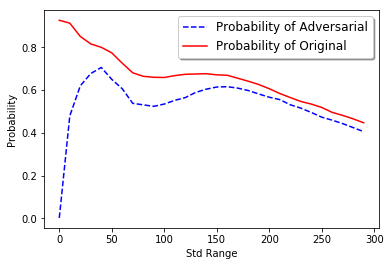

In [10]:
import matplotlib.pyplot as plt
#综合分析滤波对 对抗样本和正常图片分类的影响
std_range = range(0,300,10)
original_pro = []
adv_pro = []

for i in std_range:
    
    bilateralFilter_adv_img=cv2.bilateralFilter(adv.copy(),11,i,i)
    pro_388=infer_img(bilateralFilter_adv_img.copy(),388) 
    adv_pro+= [pro_388]
    
    bilateralFilter_img=cv2.bilateralFilter(orig.copy(),11,i,i)
    pro=infer_img(bilateralFilter_img.copy(),388)
    original_pro += [pro]
            
    print("std={} adv_pro[388]={} original_pro[388]={}".format(i,pro_388,pro))


fig, ax = plt.subplots()
ax.plot(np.array(std_range), np.array(adv_pro), 'b--', label='Probability of Adversarial')
ax.plot(np.array(std_range), np.array(original_pro), 'r', label='Probability of Original')

legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Std Range')
plt.ylabel('Probability')
plt.show()

std=0 pro[388]=0.927069902420044 pro[288]=3.175290885337745e-06
std=10 pro[388]=0.9134399890899658 pro[288]=2.0392842543515144e-06
std=20 pro[388]=0.851268470287323 pro[288]=1.540732000648859e-06
std=30 pro[388]=0.8163094520568848 pro[288]=9.021194955494138e-07
std=40 pro[388]=0.8003881573677063 pro[288]=7.407922453239735e-07
std=50 pro[388]=0.7744521498680115 pro[288]=7.558347192571091e-07
std=60 pro[388]=0.7260379195213318 pro[288]=8.909933058021124e-07
std=70 pro[388]=0.6810597777366638 pro[288]=1.0407843547000084e-06
std=80 pro[388]=0.664679765701294 pro[288]=1.13656301437004e-06
std=90 pro[388]=0.6601906418800354 pro[288]=1.2568842748805764e-06
std=100 pro[388]=0.6592541933059692 pro[288]=1.4871673101879423e-06
std=110 pro[388]=0.6679579615592957 pro[288]=1.8200437352788867e-06
std=120 pro[388]=0.6740995645523071 pro[288]=2.2889551019034116e-06
std=130 pro[388]=0.675528883934021 pro[288]=3.0377477742149495e-06
std=140 pro[388]=0.6769252419471741 pro[288]=4.166060080024181e-06
std=

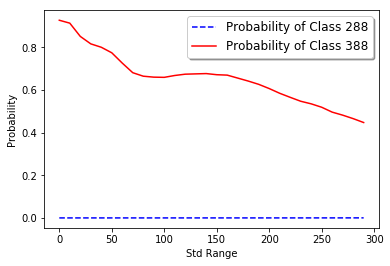

In [11]:
#验证滤波器 对抗样本的影响
std_range = range(0,300,10)
adv_288_pro = []
adv_388_pro = []

for i in std_range:
    
    bilateralFilter_img=cv2.bilateralFilter(orig.copy(),11,i,i)
    
    pro_388=infer_img(bilateralFilter_img.copy(),388)
    pro_288=infer_img(bilateralFilter_img.copy(),288)
    print("std={} pro[388]={} pro[288]={}".format(i,pro_388,pro_288))
    adv_288_pro += [pro_288]
    adv_388_pro += [pro_388]

fig, ax = plt.subplots()
ax.plot(np.array(std_range), np.array(adv_288_pro), 'b--', label='Probability of Class 288')
ax.plot(np.array(std_range), np.array(adv_388_pro), 'r', label='Probability of Class 388')

legend = ax.legend(loc='best', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#FFFFFF')

plt.xlabel('Std Range')
plt.ylabel('Probability')
plt.show()